# Self-Driving Car Engineer Nanodegree
## Image Thresholding and Color Filters

In this small project we are going to calculate the Sobel gradient of an image and apply different thresholds in order to optimise the detection of lane markings. Additionally, we are going to look at different color spaces to find a better way to distinguish white and yellow lane markings.

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 
rcParams['xtick.labelsize'] = 20 # fontsize of the tick labels
rcParams['ytick.labelsize'] = 20 # fontsize of the tick labels
rcParams['figure.subplot.hspace'] = 0.3 # fontsize of the tick labels

%matplotlib inline

# Threshold Methods

First, we are going to define a function that computes the Sobel derivative in either x or y-direction

In [2]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

In [3]:
image = mpimg.imread('test_images\signs_vehicles_xygrad.png')

We calculate thresholded binary images based on the magnitude of the gradients in x and y direction

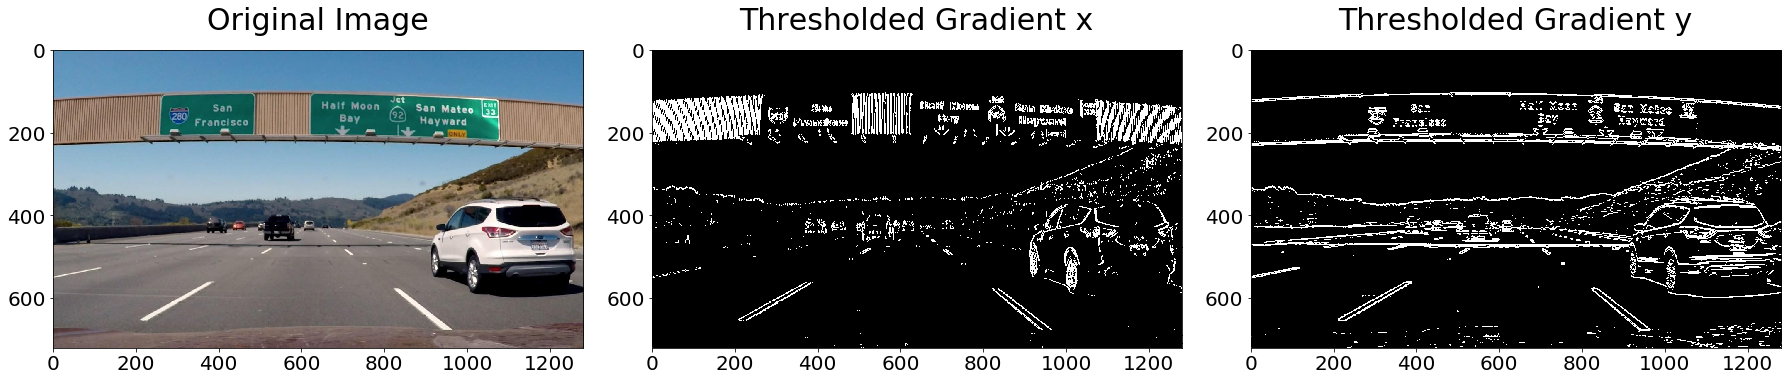

In [4]:
# Run the function
grad_binary_x = abs_sobel_thresh(image, orient='x', thresh=(20,250))
grad_binary_y = abs_sobel_thresh(image, orient='y', thresh=(20,250))
# Plot the result
f, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(grad_binary_x, cmap='gray')
ax2.set_title('Thresholded Gradient x', fontsize=30)
ax3.imshow(grad_binary_y, cmap='gray')
ax3.set_title('Thresholded Gradient y', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

As we can see, the lane markings are clearly visible in both images. However, we pick up much more noise from the horizontal shadows in the y-gradient picture. This makes sense since the orientation of the lane marking is closer aligned with the y-axis, i.e. it's color gradient is stronger along the x-axis.

Next we are going to apply thresholds based on the total magnitude of the gradient.

In [5]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    abs_grad = np.sqrt(sobel_x**2 + sobel_y**2)
    # Rescale to 8 bit
    scaled_grad= np.uint8(255*abs_grad/np.max(abs_grad))
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(scaled_grad)
    binary_output[(scaled_grad >= mag_thresh[0]) & (scaled_grad <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

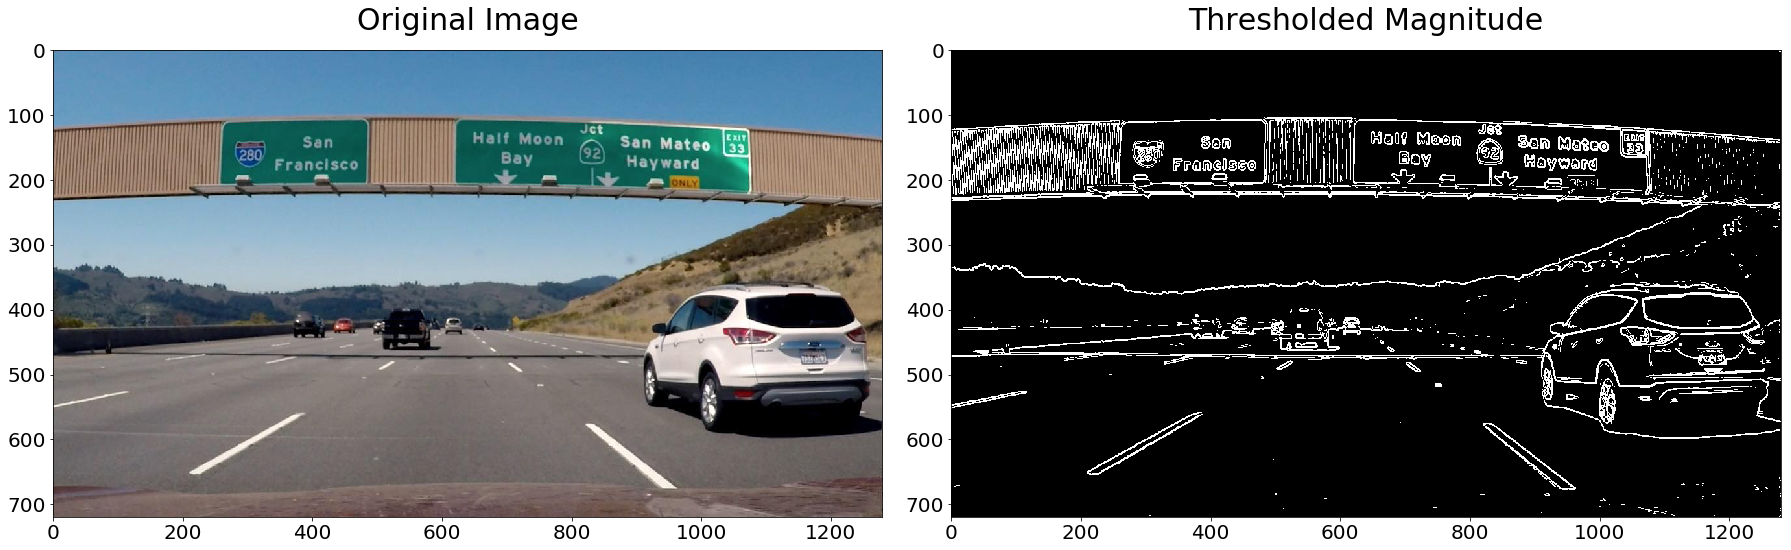

In [6]:
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(40, 250))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Now we still pick up the horizontal lines from the shadows but the lane lines are also clearly visible. So, let's try a directional approach next.

In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    abs_sobel = np.arctan2(abs_sobel_y, abs_sobel_x)
    # 5) Create a binary mask where direction thresholds are met
    binary = np.zeros_like(abs_sobel)
    binary[(abs_sobel >=thresh[0]) & (abs_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary

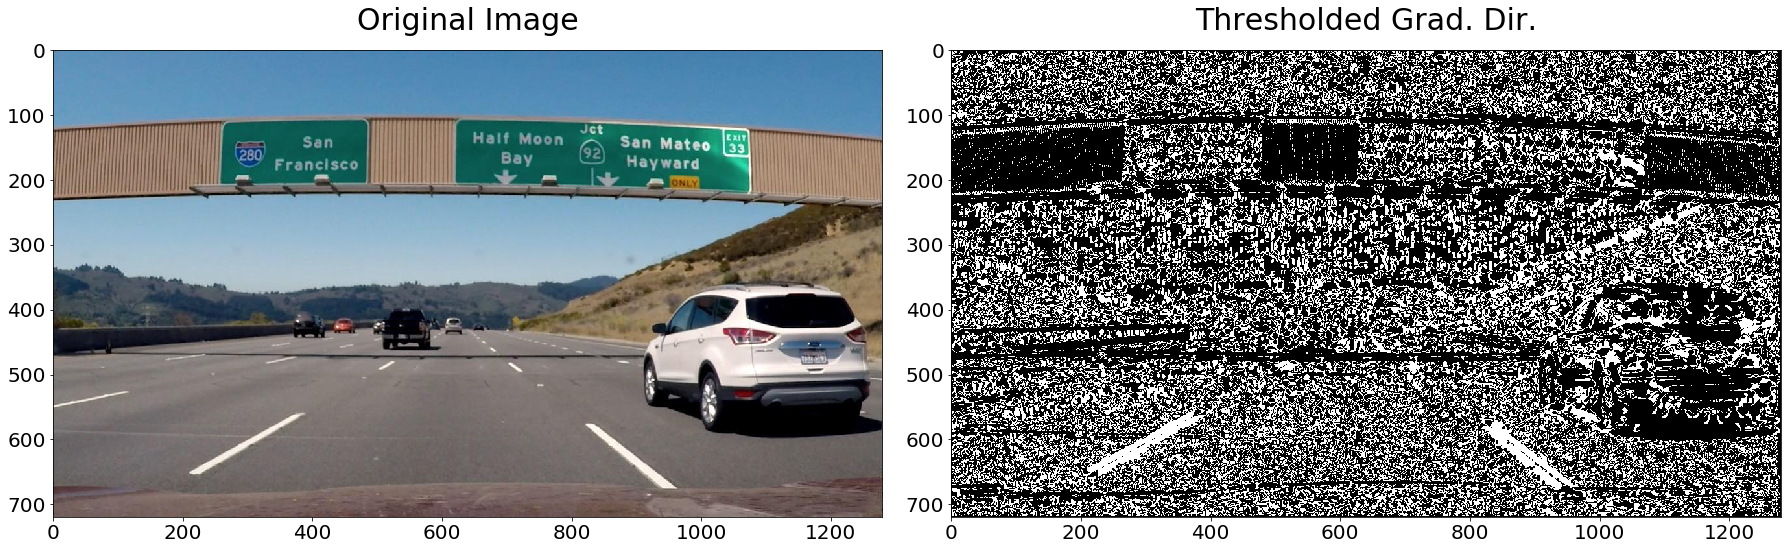

In [8]:
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

As we can see, with the selected thresholds, the lane lines are clearly visible, along with all kinds of noise. However, the horizontal shadow completely disappeared. In the next step we are going to combine the different approaches of thresholding to create a better filter.

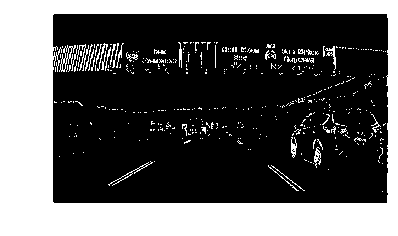

In [9]:
# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(40, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, 2*np.pi/5))
                                                              
# Combine thresholds
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(combined, 'gray')
plt.show()

Combining the directional thresholds with the normal gradient thresholds gives a much clearer highlighting of the lane markings.

# Color Spaces

So far, we have restricted ourselves to grayscale images converted from RGB only. However, to make better use of the color information in our images it makes sense to examine other color spaces as well. To this end we will examine our image in HLS and HSV color space:

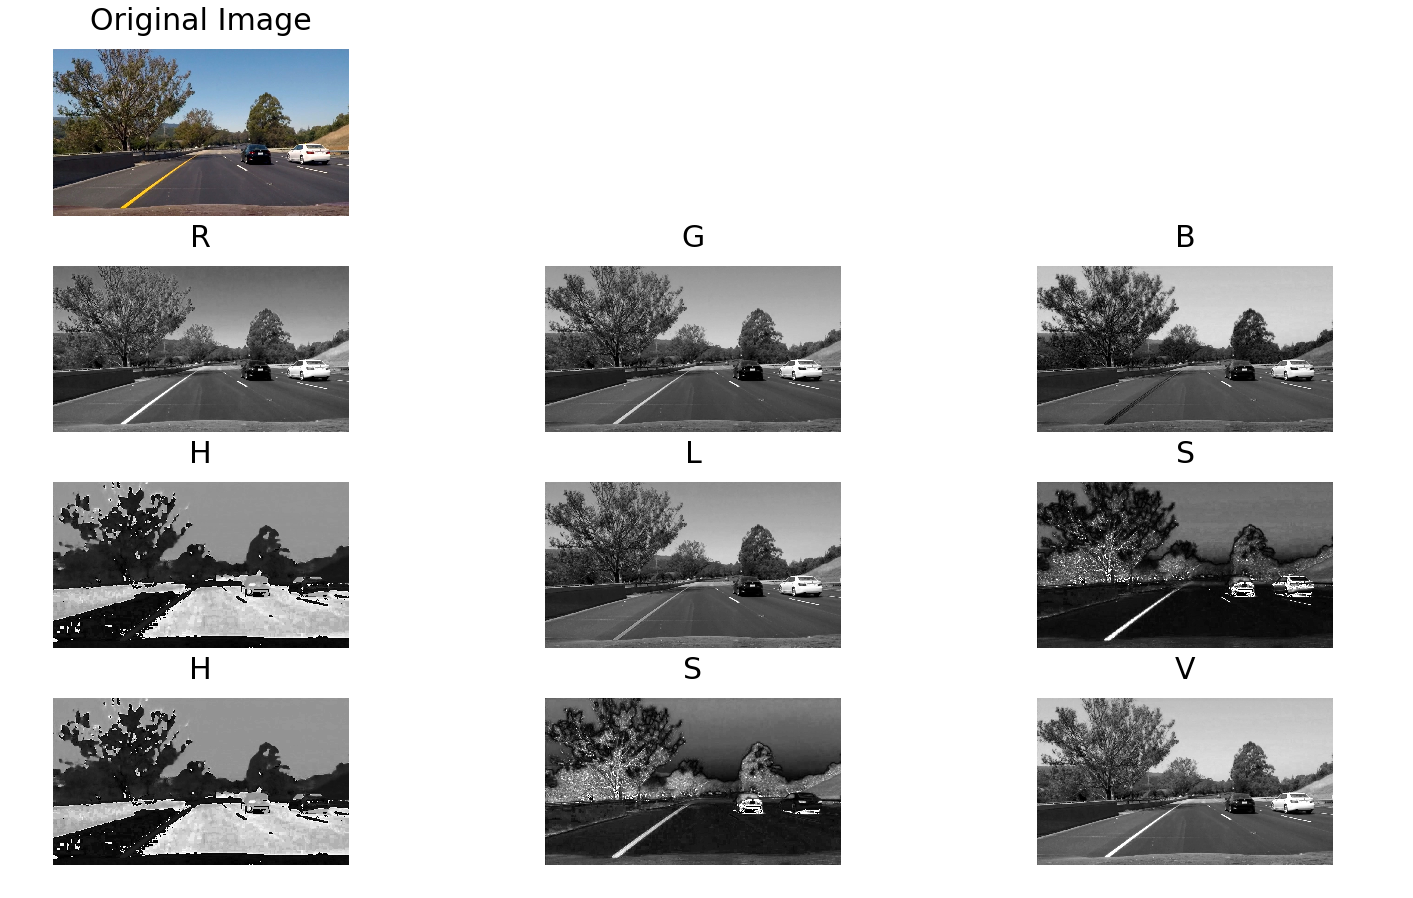

In [10]:
image = mpimg.imread('test_images/test6.jpg')
# RGB channels
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
H1 = hsv[:,:,0]
S1 = hsv[:,:,1]
V1 = hsv[:,:,2]
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 3, figsize=(25, 15))
ax1[0].imshow(image)
ax1[0].set_title('Original Image', fontsize=30)
ax1[0].axis('off')
ax1[1].axis('off')
ax1[2].axis('off')
ax2[0].imshow(R, cmap='gray')
ax2[0].set_title('R', fontsize=30)
ax2[0].axis('off')
ax2[1].imshow(G, cmap='gray')
ax2[1].set_title('G', fontsize=30)
ax2[1].axis('off')
ax2[2].imshow(B, cmap='gray')
ax2[2].set_title('B', fontsize=30)
ax2[2].axis('off')
ax3[0].imshow(H, cmap='gray')
ax3[0].set_title('H', fontsize=30)
ax3[0].axis('off')
ax3[1].imshow(L, cmap='gray')
ax3[1].set_title('L', fontsize=30)
ax3[1].axis('off')
ax3[2].imshow(S, cmap='gray')
ax3[2].set_title('S', fontsize=30)
ax3[2].axis('off')
ax4[0].imshow(H1, cmap='gray')
ax4[0].set_title('H', fontsize=30)
ax4[0].axis('off')
ax4[1].imshow(S1, cmap='gray')
ax4[1].set_title('S', fontsize=30)
ax4[1].axis('off')
ax4[2].imshow(V1, cmap='gray')
ax4[2].set_title('V', fontsize=30)
ax4[2].axis('off')
plt.show()

As we can see, it seems like the S-channels alone do a very good job of filtering for the yellow line in this image. If we restrict ourselves to RGB then the R-channel seems to do the best job. Let's have a look at another picture:

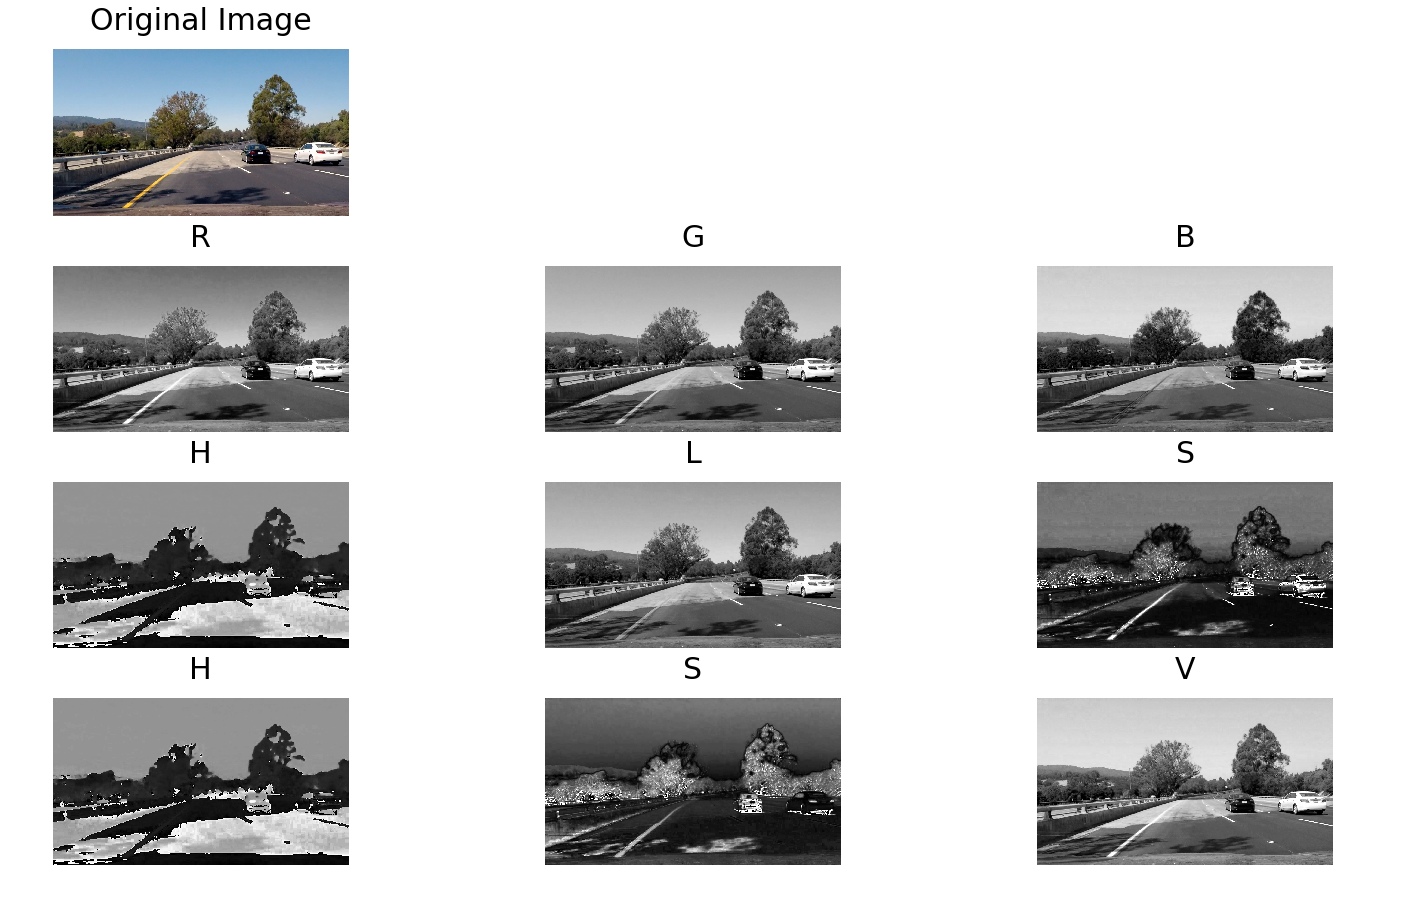

In [11]:
image = mpimg.imread('test_images/test4.jpg')
# RGB channels
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
H1 = hsv[:,:,0]
S1 = hsv[:,:,1]
V1 = hsv[:,:,2]
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 3, figsize=(25, 15))
ax1[0].imshow(image)
ax1[0].set_title('Original Image', fontsize=30)
ax1[0].axis('off')
ax1[1].axis('off')
ax1[2].axis('off')
ax2[0].imshow(R, cmap='gray')
ax2[0].set_title('R', fontsize=30)
ax2[0].axis('off')
ax2[1].imshow(G, cmap='gray')
ax2[1].set_title('G', fontsize=30)
ax2[1].axis('off')
ax2[2].imshow(B, cmap='gray')
ax2[2].set_title('B', fontsize=30)
ax2[2].axis('off')
ax3[0].imshow(H, cmap='gray')
ax3[0].set_title('H', fontsize=30)
ax3[0].axis('off')
ax3[1].imshow(L, cmap='gray')
ax3[1].set_title('L', fontsize=30)
ax3[1].axis('off')
ax3[2].imshow(S, cmap='gray')
ax3[2].set_title('S', fontsize=30)
ax3[2].axis('off')
ax4[0].imshow(H1, cmap='gray')
ax4[0].set_title('H', fontsize=30)
ax4[0].axis('off')
ax4[1].imshow(S1, cmap='gray')
ax4[1].set_title('S', fontsize=30)
ax4[1].axis('off')
ax4[2].imshow(V1, cmap='gray')
ax4[2].set_title('V', fontsize=30)
ax4[2].axis('off')
plt.show()

Here too the S and R channels seem to clearly isolate the lane markings. 

Let's have a look at the more complicated filter I used in project 1 and compare it to a direct threshold filter on the HLS S channel combined with the R channel.

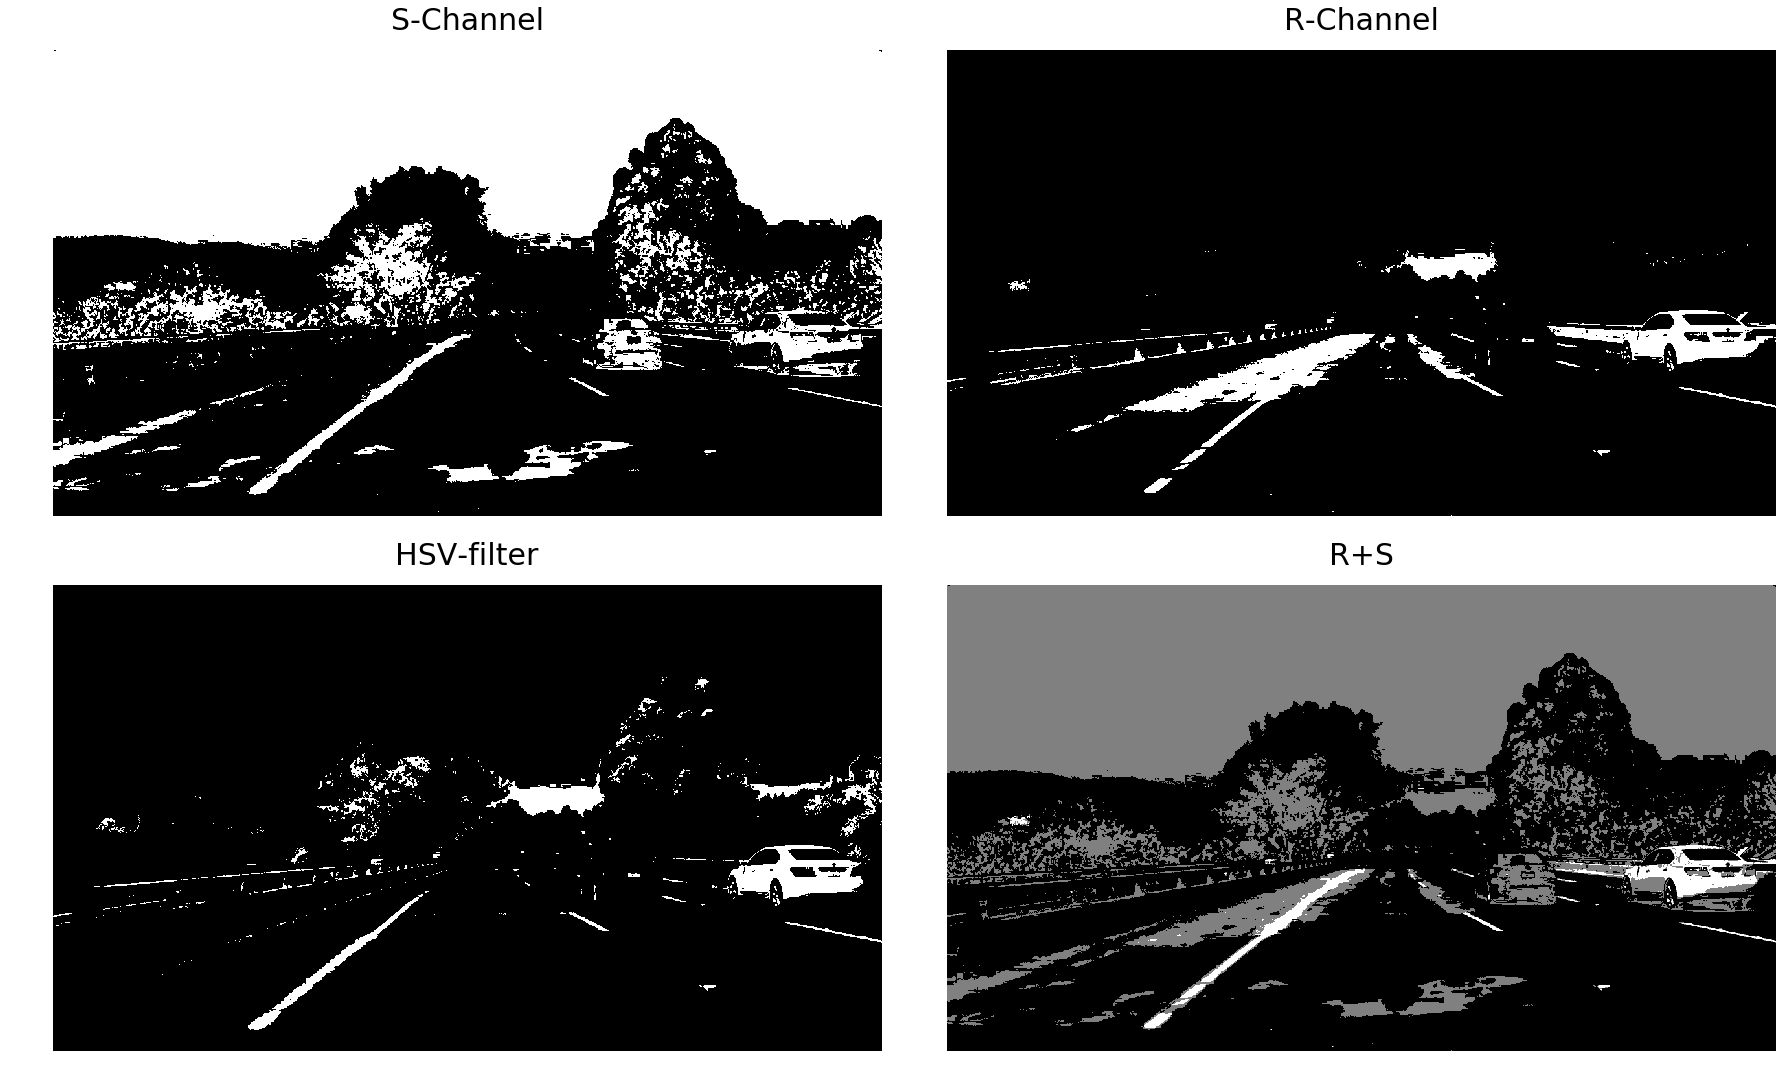

In [12]:
# yellow+white filter
light_yellow = (18, 100, 100)
dark_yellow = (30,255,255)
lower_white = (0, 0, 200)
upper_white = (255,30,255)
image_yellow = cv2.inRange(hsv, light_yellow, dark_yellow)
image_white = cv2.inRange(hsv, lower_white, upper_white)
ret_image_1 = image_white+image_yellow

s_thresh = (90, 255)
s_binary = np.zeros_like(S)
s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1

r_thresh = (200, 255)
r_binary = np.zeros_like(R)
r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1

ret_image_2 = s_binary + r_binary

f, (ax1, ax2) = plt.subplots(2, 2, figsize=(25, 15))
f.tight_layout()
ax1[0].set_title('S-Channel', fontsize=30)
ax1[0].imshow(s_binary, 'gray')
ax1[0].axis('off')
ax1[1].set_title('R-Channel', fontsize=30)
ax1[1].imshow(r_binary, 'gray')
ax1[1].axis('off')
ax2[0].set_title('HSV-filter', fontsize=30)
ax2[0].imshow(ret_image_1, 'gray')
ax2[0].axis('off')
ax2[1].set_title('R+S', fontsize=30)
ax2[1].imshow(ret_image_2, 'gray')
ax2[1].axis('off')
plt.show()

It seems like the more sophisticated filter from Project 1 coincidentally still performs better but it might still be worth to test both filters under different lighting conditions.

# Combining Color Thresholds and Gradients

In the following we will stack color gradient and threshold maps to see the different contributions of the methods:

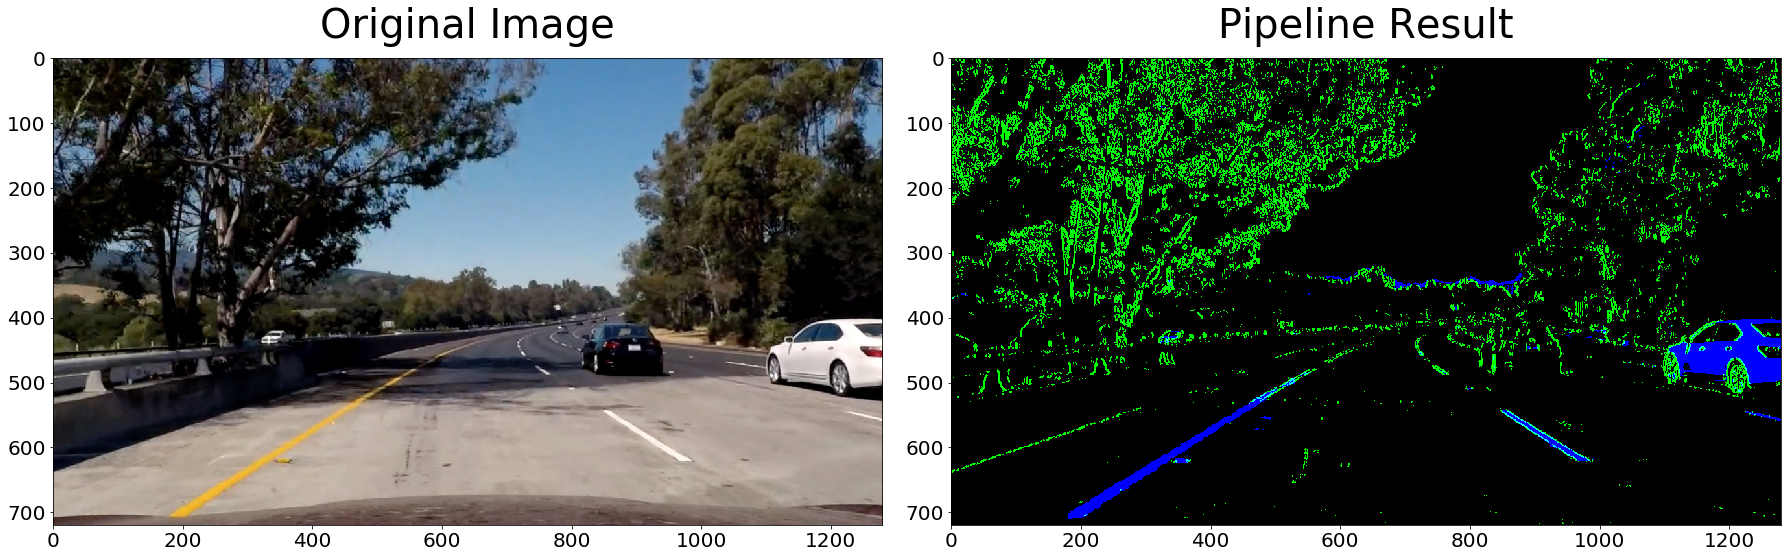

In [13]:
image = mpimg.imread('test_images/bridge_shadow.jpg')

light_yellow = (18, 100, 100)
dark_yellow = (30,255,255)
lower_white = (0, 0, 200)
upper_white = (255,30,255)
ksize=3

# Edit this function to create your own pipeline.
def pipeline(img):
    img = np.copy(img)
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(25, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(25, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 255))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, 2*np.pi/5))
                                                              
    # Combine thresholds
    combined_sobel = np.zeros_like(dir_binary)
    combined_sobel[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    image_yellow = cv2.inRange(hsv, light_yellow, dark_yellow)
    image_white = cv2.inRange(hsv, lower_white, upper_white)
    hsv_filter_image = image_white+image_yellow
    
    color_binary = np.dstack(( np.zeros_like(combined_sobel), combined_sobel, hsv_filter_image*255))
    return color_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)